# Project 4E: West Nile Virus presence analysis

### Overall Contents:
- Background
- Data Cleaning
- Exploratory Data Analysis
- Modeling 1 Logistic Regression
- Modeling 2 k-Nearest Neighbours
- [Modeling 3 Random Forest](#6.-Modeling-3-Random-Forest) **(In this notebook)**
- Evaluation
- Conclusion and Recommendation

## 6. Modeling 3 Random Forest

### 6.1 Libraries Import

In [1]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier


from estimators import EstimatorChecker
from statsmodels.stats.contingency_tables import mcnemar

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
# Maximum display of columns
pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 400

### 6.2 Data Import  

While importing the data, we will dummify the `species` column.

In [2]:
# Import data of train, weather, spray and test from csv
train_df = pd.read_csv('../data/train_df_model.csv')
test_df = pd.read_csv("../data/test_df_model.csv")

train_df.date = pd.to_datetime(train_df.date)
test_df.date = pd.to_datetime(test_df.date)

In [3]:
train_df = train_df.set_index('date', drop=True)

In [4]:
train_df.drop(['latitude','longitude'],axis=1,inplace=True)
test_df.drop(['latitude','longitude'],axis=1,inplace=True)

- Dummify the species column for both datasets, making sure to drop_first for the test set as it has an extra species

In [5]:
train_df = pd.get_dummies(train_df, columns = ['species'])

test_df = pd.get_dummies(test_df, columns = ['species'], drop_first=True)

#### Balancing the classes  

As there is a large imbalance of classes in our dataset, we will attempt to fix this imbalance by undersampling and oversampling the dataset.

In [6]:
# Set a random seed
np.random.seed(42)

In [7]:
# Count the values of each class
count_class_0, count_class_1 = train_df.wnvpresent.value_counts()

# Divide the dataset by each class
df_class_0 = train_df[train_df['wnvpresent'] == 0]
df_class_1 = train_df[train_df['wnvpresent'] == 1]

- Create a dataframe for the undersampled dataset

Random under-sampling:
1    551
0    551
Name: wnvpresent, dtype: int64


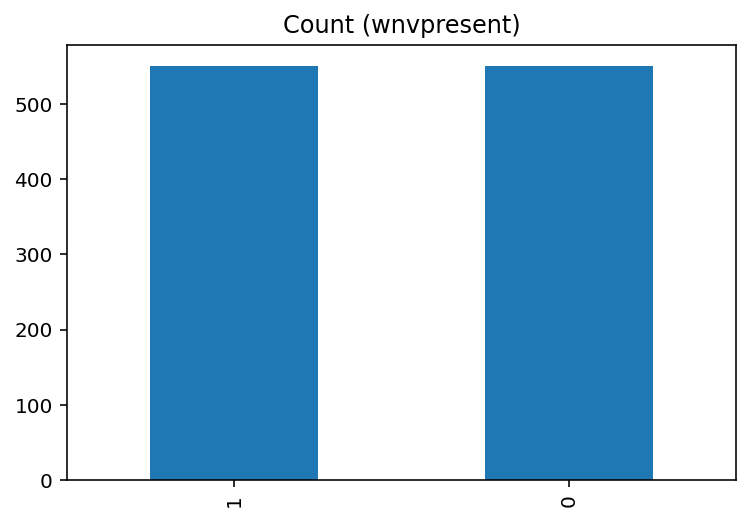

In [8]:
# Pick random samples from the larger class and add it to a new dataframe with the smaller class
df_class_0_under = df_class_0.sample(count_class_1)
train_df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(train_df_under.wnvpresent.value_counts())

# Plot this dataframe to see the balance
train_df_under.wnvpresent.value_counts().plot(kind='bar', title='Count (wnvpresent)');

plt.savefig(fname='../imgs/rftrainunder.png')

The undersampled dataset only has a 551 values for each class, which is a very small amount. Hence we will not use it as there is significant dataloss of over 90%.

- Create a dataframe for the oversampled dataset

Random over-sampling:
1    9955
0    9955
Name: wnvpresent, dtype: int64


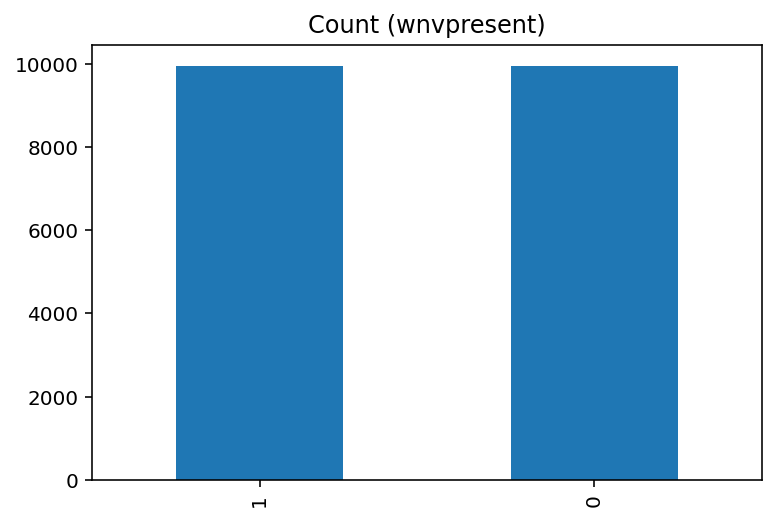

In [9]:
# Pick random samples from the smaller class with resampling and add it to a new dataframe with the larger class
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
train_df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(train_df_over.wnvpresent.value_counts())

# Plot this dataframe to see the balance
train_df_over.wnvpresent.value_counts().plot(kind='bar', title='Count (wnvpresent)');

plt.savefig(fname='../imgs/rftrainover.png')

### 6.3 Baseline Accuracy  and Train/Test Split

The baseline accuracy is the percentage of the majority class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat.

In [10]:
X = train_df.drop('wnvpresent',axis=1)
y = train_df['wnvpresent']

We will set a baseline accuracy for the oversampled dataset as well

In [11]:
X_over = train_df_over.drop('wnvpresent',axis=1)
y_over = train_df_over['wnvpresent']

In [12]:
print(f'baseline accuracy: {1-y.sum()/len(y)}')
print(f'baseline accuracy oversampled: {1-y_over.sum()/len(y_over)}')

baseline accuracy: 0.9475537787930707
baseline accuracy oversampled: 0.5


In this case, our baseline accuracy is roughly 0.948, or 94.8% without West Nile Virus.  

In order to train and test our model without data leakage, we will split the training further into a training and testing set using train_test_split.  

With the baseline accuracy being 0.9475, this suggests that there is a serious imbalance of classes. Hence we will stratify y in our split.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

### 6.4 Finding the best parameters for RandomForestClassifier  



In [14]:
# Create a dictionary of estimators that we want to check
estimators = {
    'rfc': RandomForestClassifier()
}

In [15]:
# Create a dictionary of parameters for the estimators that we want to check
params = {
    'rfc': {'n_estimators': [5,10,20,40,50,75,100,125,150,175], 'max_depth': [None, 2, 3, 4, 5, 7, 9, 11],'max_features': ['sqrt','log2',1/3], 'random_state': [42]}
}

In [16]:
# Instantiate an instance of the EstimatorChecker class with the estimators and parameters.
estimators_check = EstimatorChecker(estimators, params)

# Fit the instance with the transformed X_train and the y_train to train and score the model
estimators_check.fit(X_train, y_train)

Running GridSearchCV for rfc.
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [17]:
# Check the top parameters in terms of mean_score 
estimators_check.score_summary(sort_by='mean_score').head()

rfc


,estimator,min_score,mean_score,max_score,std_score,max_depth,max_features,n_estimators,random_state
202,rfc,0.946701,0.947963,0.949239,0.0011279,9,0.333333,20,42
171,rfc,0.947302,0.947963,0.949873,0.000987389,7,0.333333,10,42
203,rfc,0.947335,0.947836,0.949206,0.000727821,9,0.333333,40,42
232,rfc,0.947335,0.947836,0.949239,0.000738953,11,0.333333,20,42
212,rfc,0.947335,0.947836,0.948604,0.000473245,11,sqrt,20,42


- Fit the best estimator with our training data

In [18]:
rf = estimators_check.best_estimator

In [19]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=9, max_features=0.3333333333333333,
                       n_estimators=20, random_state=42)

- Print the classification report to see our scores for this estimator

In [20]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2489
           1       0.38      0.02      0.04       138

    accuracy                           0.95      2627
   macro avg       0.66      0.51      0.51      2627
weighted avg       0.92      0.95      0.92      2627



The mean scores for the RandomForestClassifier on the regular dataset is barely better than the baseline accuracy. However, the precision and recall scores are terrible for the prediction of WNV. Hence we will not use this model.

### 6.5 Use the oversampled dataset to find the best parameters for RandomForestClassifier

In [21]:
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_over, y_over, stratify=y_over, random_state=42)

In [22]:
# Instantiate an instance of the EstimatorChecker class with the estimators and parameters.
estimators_check_over = EstimatorChecker(estimators, params)

# Fit the instance with the transformed X_train and the y_train to train and score the model
estimators_check_over.fit(X_train_over, y_train_over)

Running GridSearchCV for rfc.
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [23]:
# Check the top parameters in terms of mean_score 
estimators_check_over.score_summary(sort_by='mean_score').head(5)

rfc


,estimator,min_score,mean_score,max_score,std_score,max_depth,max_features,n_estimators,random_state
17,rfc,0.952445,0.957072,0.961835,0.00328596,None,log2,125,42
16,rfc,0.95077,0.956938,0.962169,0.00392243,None,log2,100,42
15,rfc,0.951105,0.956938,0.96083,0.00334251,None,log2,75,42
18,rfc,0.95278,0.956871,0.9615,0.00294057,None,log2,150,42
19,rfc,0.952445,0.95667,0.961835,0.00306227,None,log2,175,42


- Fit the best estimator with our training data

In [24]:
rf_over = estimators_check_over.best_estimator

In [25]:
rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='log2', n_estimators=125, random_state=42)

- Print the classification report to see our scores for this estimator

In [26]:
print(classification_report(y_val_over, rf_over.predict(X_val_over)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2489
           1       0.93      0.99      0.96      2489

    accuracy                           0.96      4978
   macro avg       0.96      0.96      0.96      4978
weighted avg       0.96      0.96      0.96      4978



This time both the weighted avg, and f1-scores are good.

- Create a dataframe with the predicted probabilities against the true y values

In [27]:
pred_df_over = pd.DataFrame({'true_values': y_val_over,
                        'pred_probs': rf_over.predict_proba(X_val_over)[:,1]})

pred_df_over.head(10)

,true_values,pred_probs
date,,
2013-06-21,0,0.008000
2009-07-06,0,0.000000
2007-08-15,1,1.000000
2013-09-06,1,0.923454
2007-08-21,1,1.000000
2007-08-15,1,0.914529
2007-08-01,0,0.000000
2011-08-12,0,0.199709
2013-07-19,1,1.000000


- Plot the dataframe to see the distributions of our predicted probabilities against actual values

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


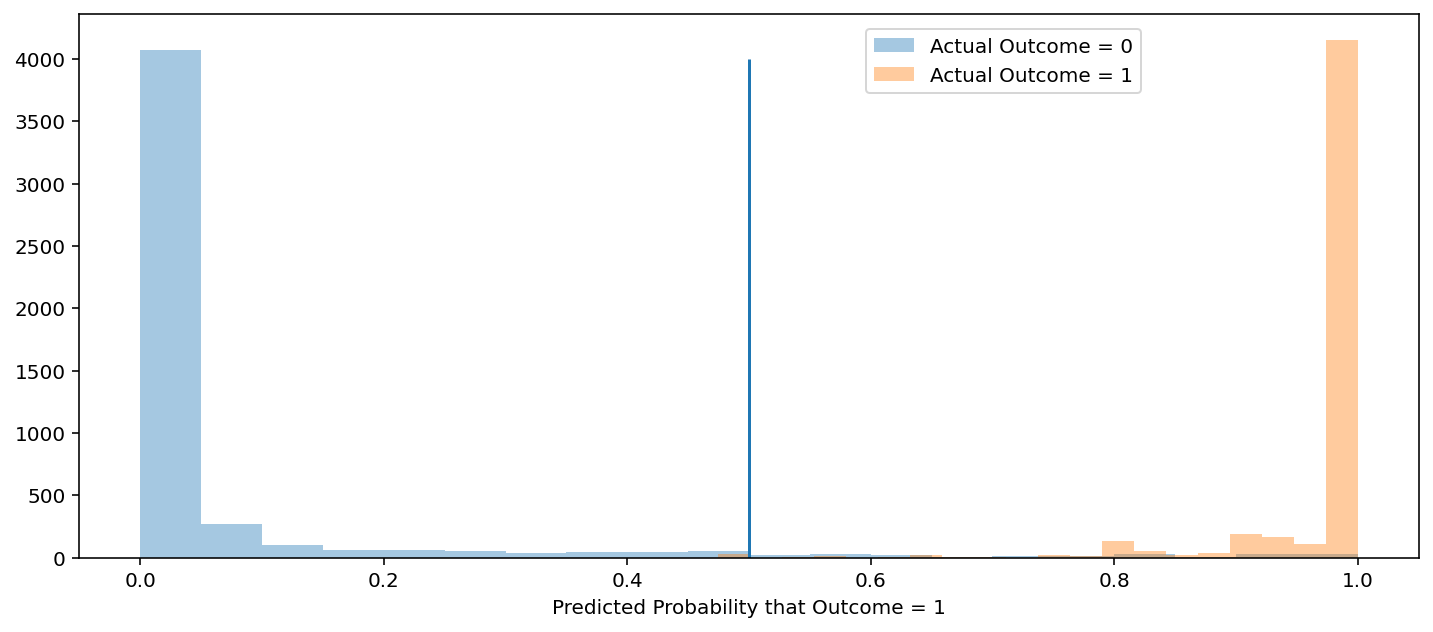

In [28]:
plt.figure(figsize = (12, 5))

# Plot distributions of predicted probabilities by actual values
for group in pred_df_over.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Plot the cutoff line
plt.vlines(x = 0.5, ymin = 0, ymax = 4000)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend(loc='best', bbox_to_anchor=(0.8,0.99));

plt.savefig(fname='../imgs/rfdistriover.png')

We can see that there appear to be no false negatives in our predicted probabilities now and with 0.5 as the cutoff line, there appear to be minimal false positives too.

- Plot the ROC curve of the model

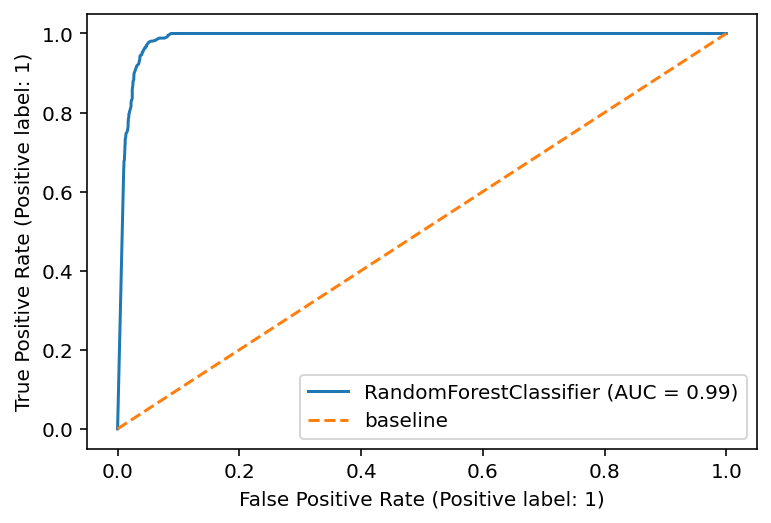

In [29]:
plot_roc_curve(rf_over, X_val_over, y_val_over)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

plt.savefig(fname='../imgs/rfroccurveover.png')

The area under curve is 0.99 which seems like a very good result. It means that 99% of predictions were correct, which is better than the baseline model.

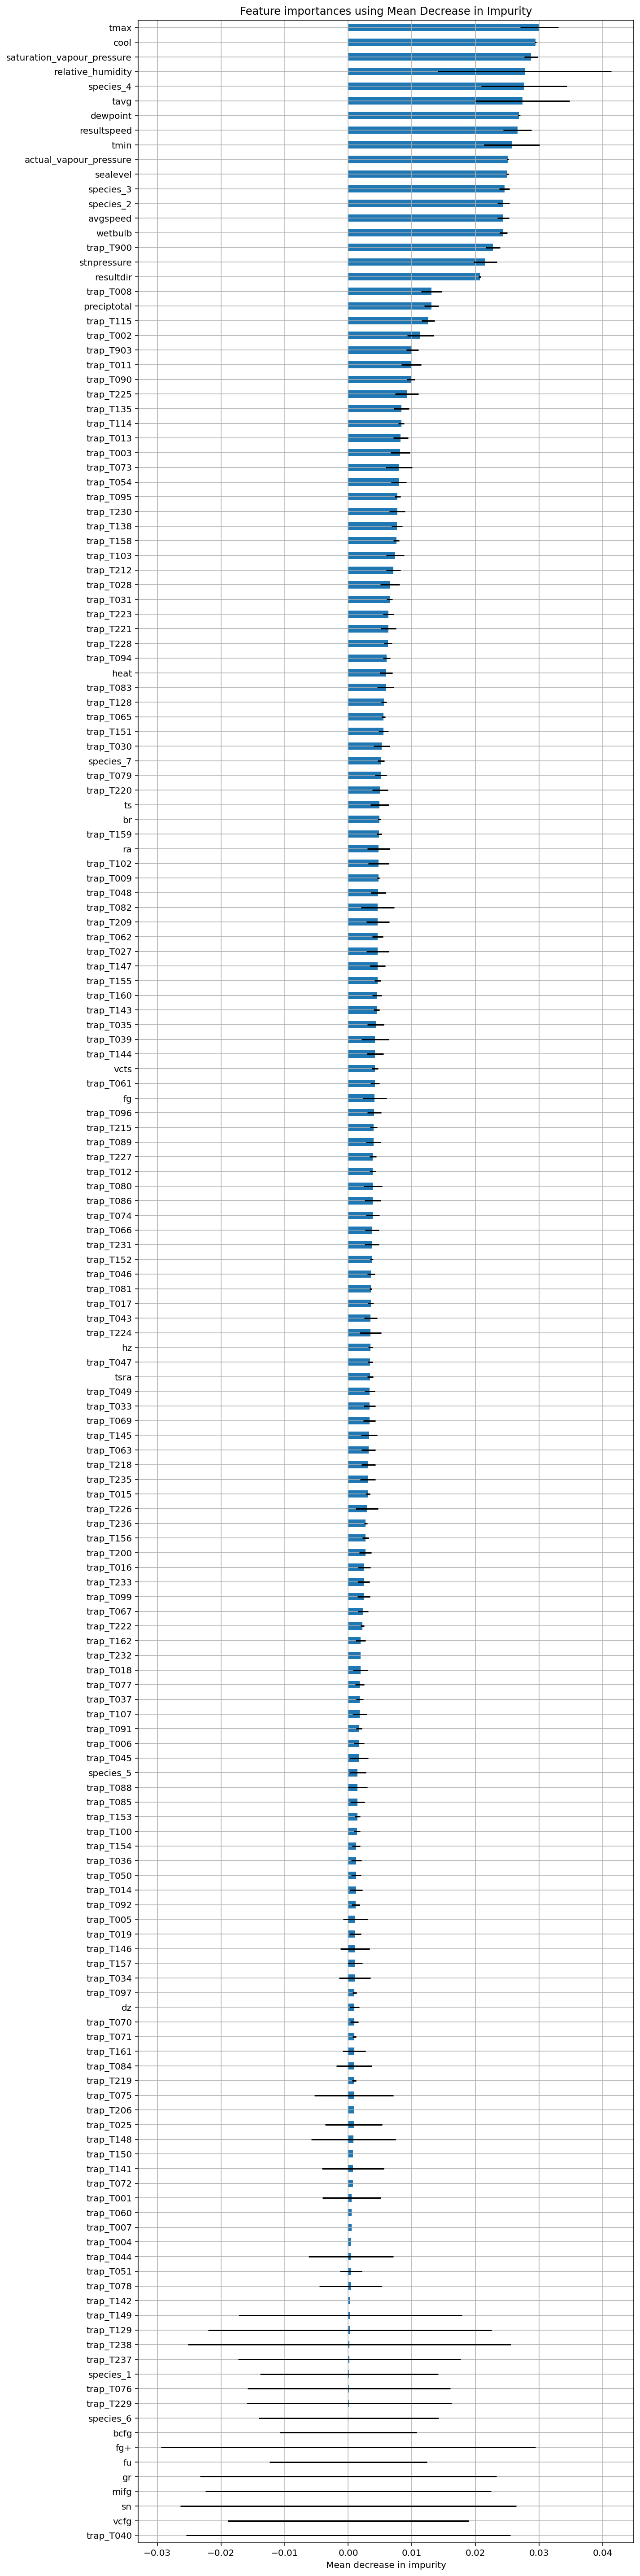

In [30]:
# Set feature importances and calculate standard deviation
importances = rf_over.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf_over.estimators_], axis=0)
# Put feature importances in a series and sort it
forest_importances = pd.Series(importances, index=X_train_over.columns).sort_values()
# Plot the feature importances
plt.figure(figsize=(10,40))
forest_importances.plot.barh(xerr=std)
plt.title("Feature importances using Mean Decrease in Impurity")
plt.xlabel("Mean decrease in impurity")
plt.grid(which='major')
plt.tight_layout()

We found out that the features carrying the most importance are maximum temperature, cool, saturation vapor pressure and relative humidity.

### 6.6 Summary

When modelling the RandomForestClassifier, we dropped latitude and longitude as these are metadata which are in each of the different traps.  

Further, to deal with the imbalance of classes, oversampling was done to balance the number of WNV present and WNV not present.  

Modelling was done on both the regular dataset as well as the oversampled dataset to see the difference it makes, as we are trying to achieve the best balance between recall and precision scores to predict where and when mosquito populations will test positive as WNV carriers.

The baseline accuracy for the regular dataset was around 94.75% while the baseline accuracy for the oversampled dataset was 50%.  

Using a gridsearch for the RandomForestClassifier, we found that we were able to get a mean accuracy of 94.79% using the regular dataset, which barely better than the baseline.  

However, with the oversampled dataset, our mean accuracy improved to around 95.5%.  
We observed that now the false negatives and false positives were both being minimized, and both recall and precision scores were quite good, leading to an F1 score of 96%.  

Hence the RFC model would be a good choice given its high recall and precision, having done better than the baseline model in predicting WNV. With a good F1 score, we can increase the efforts to combat the WNV in the right locations and times with the reduction in false positives and negatives.

In [36]:
# test_preds = pd.DataFrame(range(1,len(test_df.index)+1), columns = ['Id'])

In [32]:
# test_preds['WnvPresent'] = rf_over.predict_proba(test_df.drop('date', axis=1))[:,1]

In [33]:
# test_preds.head()

In [34]:
# test_preds.to_csv('../data/rf_kaggle_test.csv', index=False)